# Importing Libraries

In [1]:
# Importing libraries
from tqdm import tqdm
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import (
    AutoModelForImageClassification,
    ViTFeatureExtractor,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
)
from datasets import load_dataset
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training
import evaluate
import numpy as np
import warnings
import os

from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
import pandas as pd
import json
import matplotlib.pyplot as plt

from utils import parse_args, gather_metrics, plot_metrics, perform_lora_svd, plot_lora_svd_singular_values, plot_histogram
from my_statistics import gini_coefficient, elbow_method_count, energy_ratio_test_count

from scipy import stats

# Set warnings to ignore to keep output clean
warnings.filterwarnings('ignore')

/home/rft38/.conda/envs/ML-6784/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plotting Results
## 1. Full ViT fine-tuning

In [2]:
# Obtaining the train data
with open("out/base_metric_results.json") as f:
  training_data = json.load(f)

In [3]:
# Obtaining best accuracy for each number of classes
def gather_best(data, dataset):
  output = {}

  for key in data[dataset].keys():
      best_acc = data[dataset][key]['Best Results']['Validation Accuracy']
      num_classes = len(key.split('-'))

      if num_classes not in output:
          output[num_classes] = []

      output[num_classes].append(best_acc)
  
  return output

best_accs_stan = gather_best(training_data, 'stanford-dogs')
best_accs_ox = gather_best(training_data, 'oxford-pet')

For the Stanford Dog dataset:


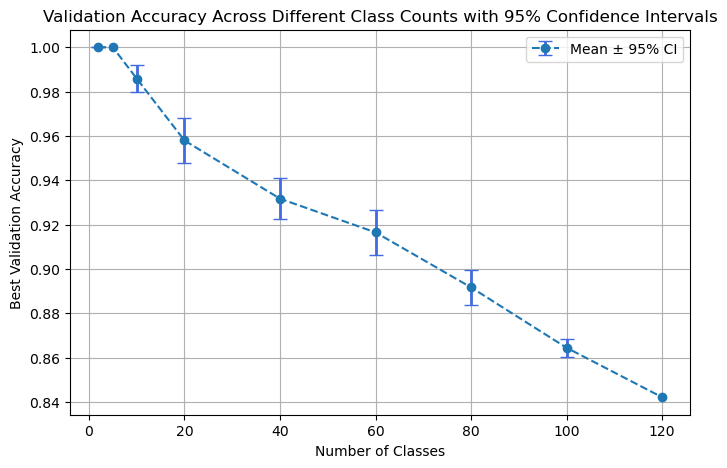

For the Oxford Pet dataset:


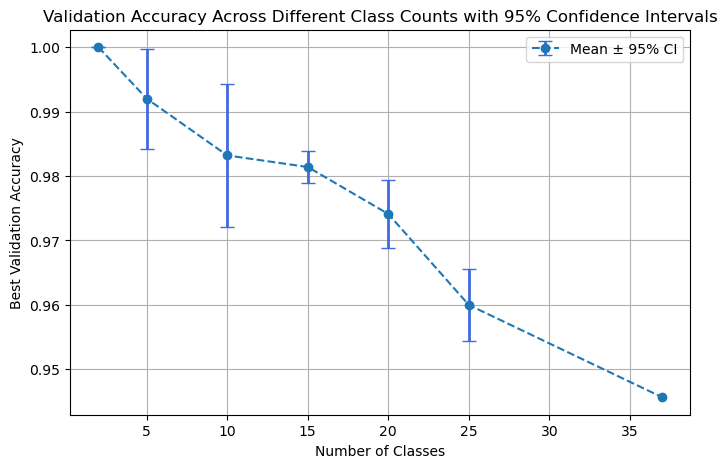

In [4]:
# Plotting best accuracies vs. number of classes
def plot_finetune_data(dataset_train_data):
    plt.figure(figsize=(8, 5))
    
    # Extract x values and corresponding y arrays
    x_values = list(dataset_train_data.keys())
    y_values = [np.array(dataset_train_data[x]) for x in x_values]

    # Compute mean and confidence intervals
    means = [np.mean(y) for y in y_values]
    std_devs = [np.std(y, ddof=1) for y in y_values]
    sample_sizes = [len(y) for y in y_values]
    conf_intervals = [1.96 * (std / np.sqrt(n)) for std, n in zip(std_devs, sample_sizes)]

    # Sort data by x-values
    sorted_data = sorted(zip(x_values, means, conf_intervals), key=lambda x: x[0])
    x_sorted, means_sorted, conf_intervals_sorted = zip(*sorted_data)

    # Plot the means and confidence intervals using error bars
    plt.errorbar(
        x_sorted, 
        means_sorted, 
        yerr=conf_intervals_sorted, 
        fmt="--o", 
        ecolor='royalblue', 
        elinewidth=2, 
        capsize=5, 
        label='Mean ± 95% CI'
    )

    # Add labels, legend, and grid
    plt.xlabel('Number of Classes')
    plt.ylabel('Best Validation Accuracy')
    plt.title('Validation Accuracy Across Different Class Counts with 95% Confidence Intervals')
    plt.legend()
    plt.grid(True)
    return plt.show()

print("For the Stanford Dog dataset:")
plot_finetune_data(best_accs_stan)
print("For the Oxford Pet dataset:")
plot_finetune_data(best_accs_ox)

## 2. LoRA ViT fine-tuning

In [ ]:
# Obtaining the train data
training_data = {}
with open("out/lora_oxford-pet_results.json") as f:
  training_data['oxford-pet'] = json.load(f)
with open("out/lora_stanford-dogs_results.json") as f:
  training_data['stanford-dogs'] = json.load(f)

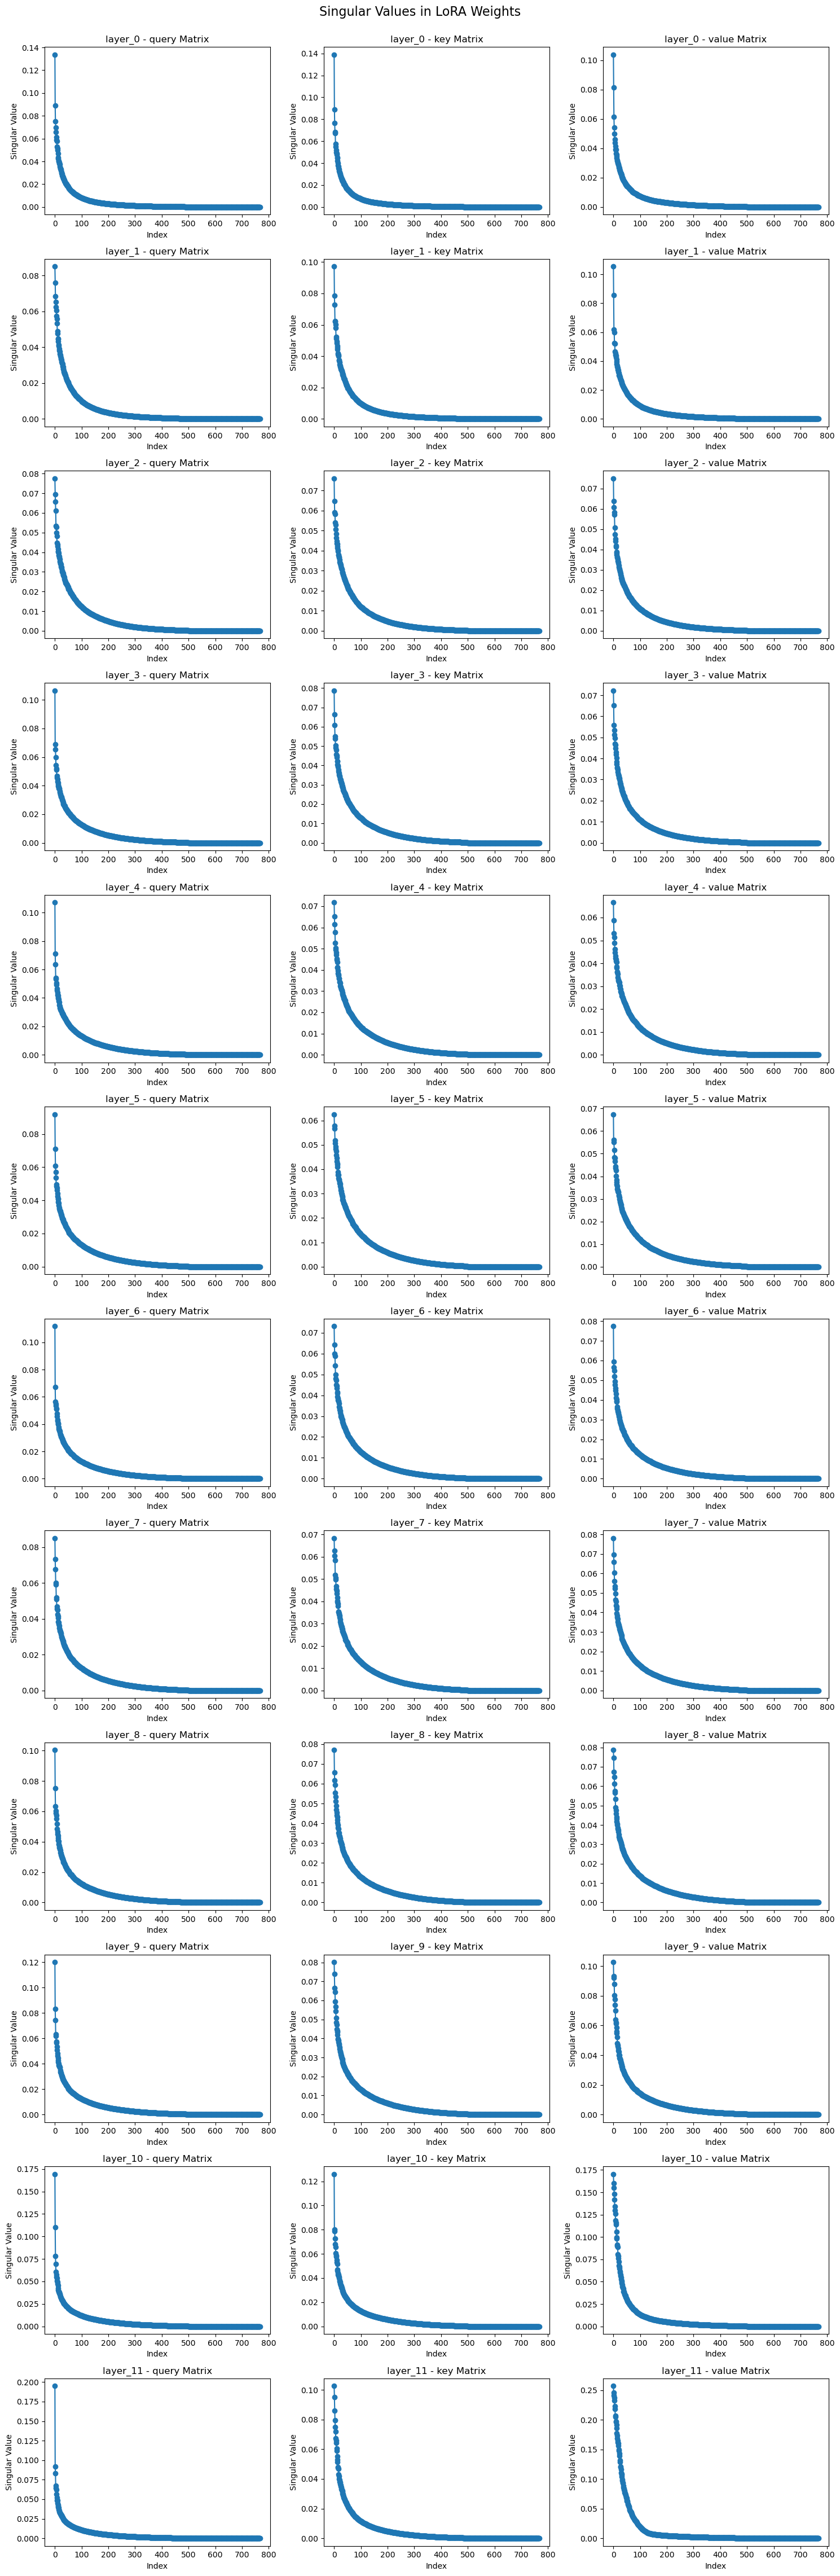

In [6]:
# Singular values for stanford dogs when training on all the data (Example)
plot_data = training_data['stanford-dogs']['-'.join([str(i) for i in range(120)])]['SVD Diagonal Entries']
plot_lora_svd_singular_values(plot_data)

In [7]:
# Given the training SVDs, one for each LoRA matrix, calculate all the GINI coefficients, energy and elbow cutoffs
def gather_train_svd_coeffs(train_svds):
    train_svds = train_svds['SVD Diagonal Entries']
    coeffs = {
        "gini": [], 
        "energy": [], 
        "elbow": []
    }

    for v in train_svds.values():
        for att_type in ['query', 'key', 'value']:
            
            coeffs['gini'].append(gini_coefficient(v[att_type]))
            coeffs['energy'].append(energy_ratio_test_count(v[att_type], energy_threshold=0.95))
            coeffs['elbow'].append(elbow_method_count(v[att_type]))

    return coeffs

In [8]:
# Recording different indices
stat_data = training_data['stanford-dogs']['-'.join([str(i) for i in range(120)])]
coeffs = gather_train_svd_coeffs(stat_data)

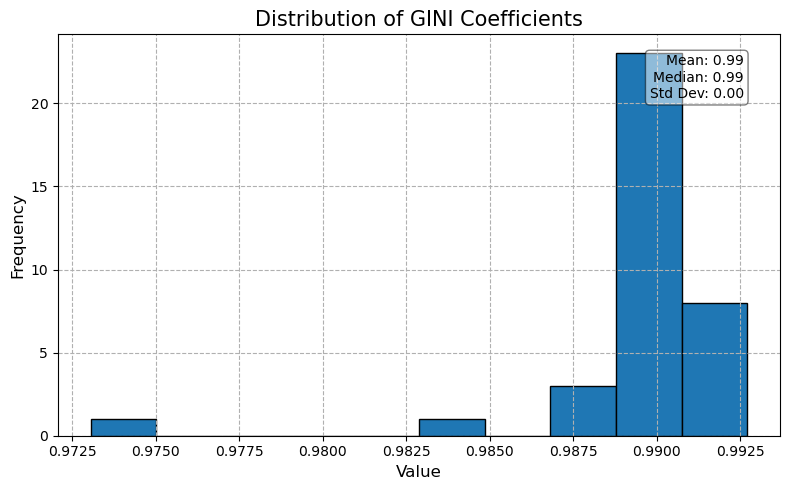

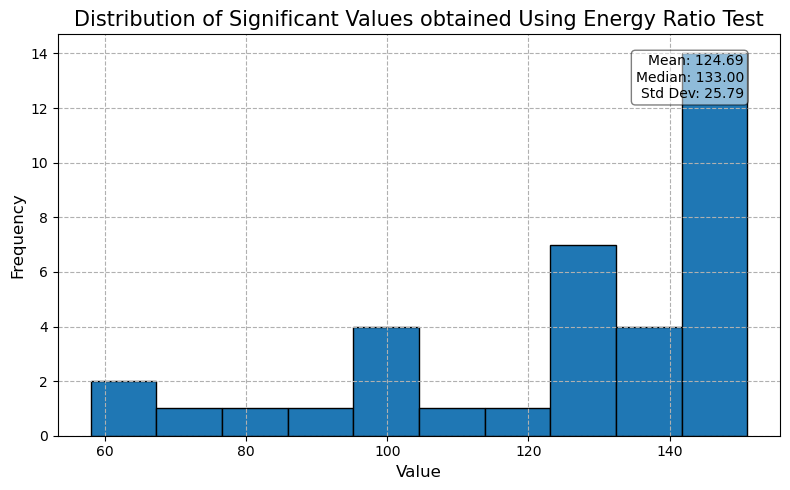

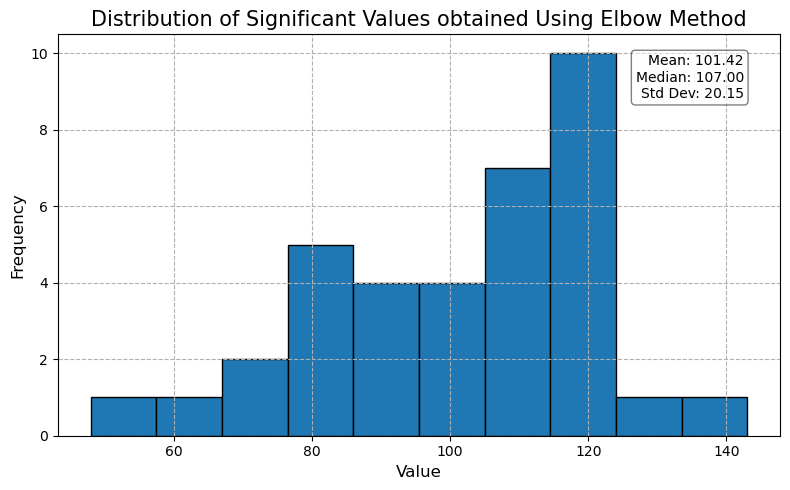

In [9]:
plot_histogram(coeffs['gini'], title="Distribution of GINI Coefficients")
plot_histogram(coeffs['energy'], title="Distribution of Significant Values obtained Using Energy Ratio Test")
plot_histogram(coeffs['elbow'], title="Distribution of Significant Values obtained Using Elbow Method")

In [10]:
# Given data and the dataset, obtain the aggregated coefficients accross all runs
def gather_coeffs(data, dataset, coefficient="gini", aggregate_method="mean"):
    output = {}

    for k, v in data[dataset].items():
        num_classes = len(k.split('-'))

        coeffs = gather_train_svd_coeffs(v)
        coeff = coeffs[coefficient]

        if aggregate_method=="mean":
            agg_coeff = np.mean(coeff)
        elif aggregate_method=="median":
            agg_coeff = np.median(coeff)

        if num_classes not in output:
            output[num_classes] = []

        output[num_classes].append(agg_coeff)
  
    return output

In [11]:
# Plotting lora SVD results 
def plot_lora_svd_coefficients(training_data, dataset, coefficient="gini", aggregate_method="mean"):
    dataset_coeffs = gather_coeffs(training_data, dataset, coefficient, aggregate_method)
    plt.figure(figsize=(8, 5))

    # Extract x values and corresponding y arrays
    x_values = list(dataset_coeffs)
    y_values = [np.array(dataset_coeffs[x]) for x in x_values]

    # Compute mean and confidence intervals
    means = [np.mean(y) for y in y_values]
    std_devs = [np.std(y, ddof=1) for y in y_values]
    sample_sizes = [len(y) for y in y_values]
    conf_intervals = [1.96 * (std / np.sqrt(n)) for std, n in zip(std_devs, sample_sizes)]

    # Sort data by x-values
    sorted_data = sorted(zip(x_values, means, conf_intervals), key=lambda x: x[0])
    x_sorted, means_sorted, conf_intervals_sorted = zip(*sorted_data)

    # Plot the means and confidence intervals using error bars
    plt.errorbar(
        x_sorted, 
        means_sorted, 
        yerr=conf_intervals_sorted, 
        fmt="--o", 
        ecolor='royalblue', 
        elinewidth=2, 
        capsize=5, 
        label='Mean ± 95% CI'
    )

    # Add labels, legend, and grid
    if coefficient=="gini":
        y_label = "GINI Coefficient"
    elif coefficient=="energy":
        y_label = "Energy-Ratio Test Cutoff"
    elif coefficient=="elbow":
        y_label = "Elbow Method Cutoff"

    plt.xlabel('Number of Classes')
    plt.ylabel(y_label)
    plt.title(f"{y_label} Across Different Class Counts with 95% Confidence Intervals")
    plt.legend()
    plt.grid(True)
    return plt.show()

For the Oxford Pet dataset:


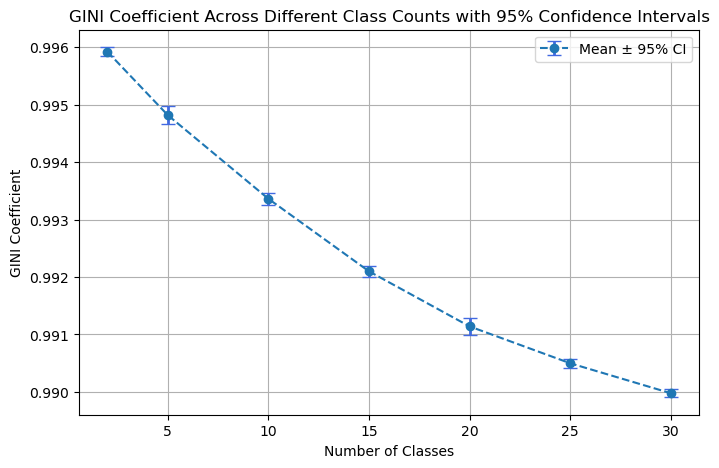

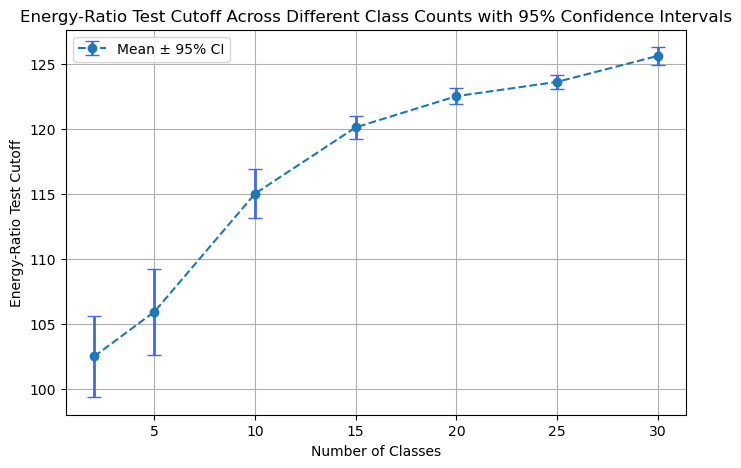

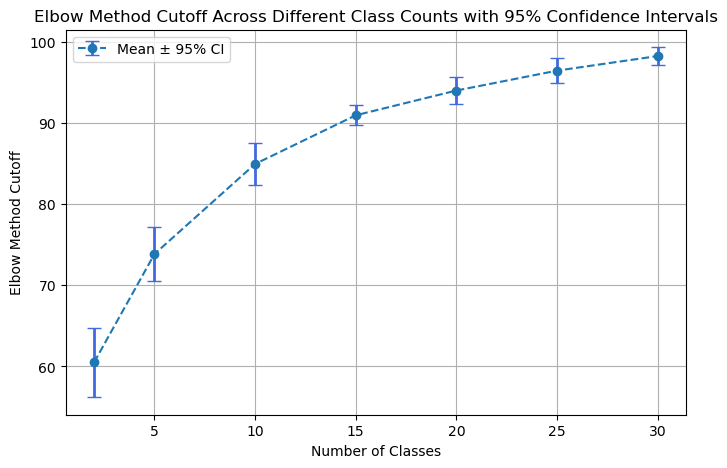

In [12]:
print("For the Oxford Pet dataset:")
plot_lora_svd_coefficients(training_data, 'oxford-pet', "gini",'median')
plot_lora_svd_coefficients(training_data, 'oxford-pet', "energy", 'median')
plot_lora_svd_coefficients(training_data, 'oxford-pet', "elbow", 'median')

For the Stanford Dogs dataset:


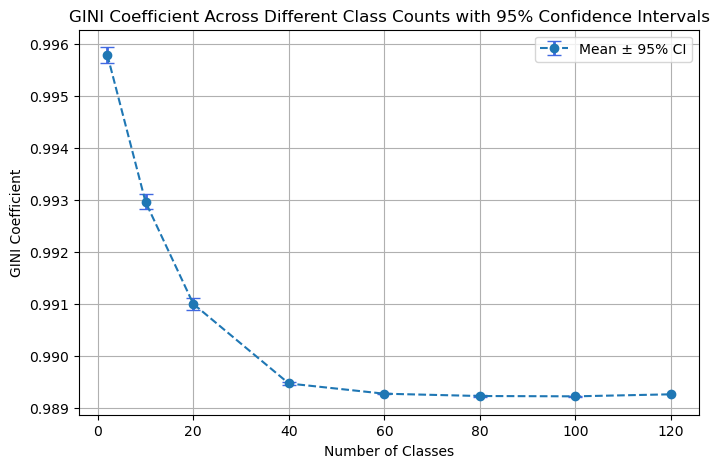

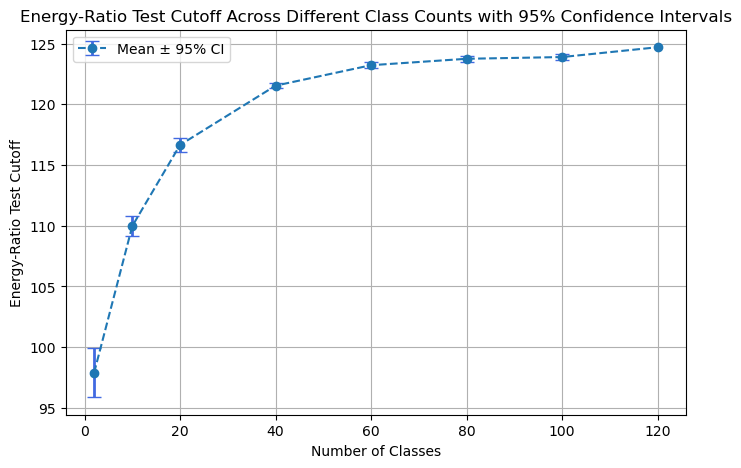

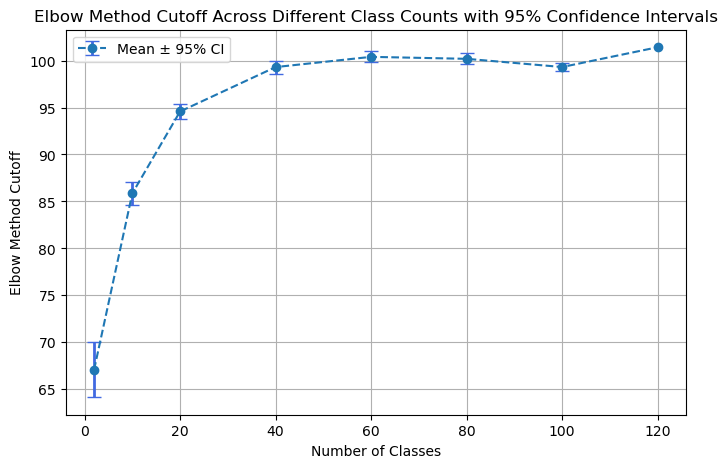

In [13]:
print("For the Stanford Dogs dataset:")
plot_lora_svd_coefficients(training_data, 'stanford-dogs', "gini")
plot_lora_svd_coefficients(training_data, 'stanford-dogs', "energy")
plot_lora_svd_coefficients(training_data, 'stanford-dogs', "elbow")